In [284]:
from numpy import genfromtxt
from PIL import Image, ImageDraw, ImageChops
import numpy as np
import cv2
import json
from matplotlib import pyplot as plt
from skimage.morphology import binary_opening, binary_closing,binary_erosion, rectangle, binary_dilation, disk
from skimage.segmentation import find_boundaries


# From Converted RJPEG To Temperature csv

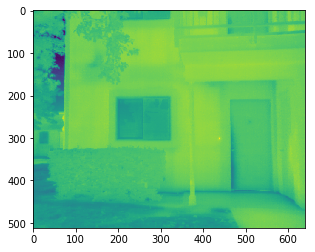

In [285]:
thermal_tab = genfromtxt('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Veracruz/Thermal_preproc/DJI_0490.csv', delimiter=',')
#thermal_tab = genfromtxt('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/singapore/Thermal_preproc/IX-x1-00057_0278_0109_THM.csv', delimiter=',')

# thermal_tab = np.rot90(thermal_tab,3)
# exclude the bottom right column because of some noise
# thermal_tab = thermal_tab[0:147,0:485]
plt.figure()
plt.imshow(thermal_tab)

In [286]:
thermal_tab.shape

(512, 640)

In [287]:
np.amax(thermal_tab)

45.6255122839727

In [288]:
np.amin(thermal_tab)

25.3353602219191

# Load mask json

In [289]:
mask_json = json.load(open('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Veracruz/masks_thm/DJI_0490.json'))

In [290]:
objects = mask_json.get("objects")[0]

In [291]:
points_lab = objects['points']

In [292]:
nested_lists = points_lab['exterior']

In [293]:
mask_polygon = [tuple(l) for l in nested_lists]

In [294]:
def getMask(original,polygon):
    #Returns the mask of the polygon
    mask = Image.new('L', (original.shape[1],original.shape[0]), 0)
    mask_draw = ImageDraw.Draw(mask)
    mask_draw.polygon(polygon, outline=1, fill=1)
    return np.array(mask, dtype=bool)

In [295]:
mask = getMask(thermal_tab,mask_polygon)

In [296]:
mask.shape

(512, 640)

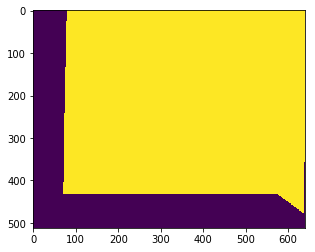

In [297]:
plt.figure()
plt.imshow(mask)

In [298]:
pixel_values = thermal_tab.reshape((-1, 1))
pixel_values = np.float32(pixel_values)
pixel_values.shape

(327680, 1)

In [299]:
mask_pixel_values = mask.reshape((-1, 1))
mask_pixel_values.shape

(327680, 1)

In [300]:
pixel_values_croped = pixel_values[mask_pixel_values].reshape((-1, 1))
pixel_values_croped.shape

(245154, 1)

In [301]:
pixel_values_croped

array([[38.681293],
       [39.031853],
       [39.32625 ],
       ...,
       [39.105522],
       [39.068695],
       [39.399734]], dtype=float32)

In [302]:
np.amax(pixel_values_croped)

45.62551

In [303]:
np.amin(pixel_values_croped)

33.73513

In [304]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [305]:
# number of clusters (K)
k = 12
_, labels, (centers) = cv2.kmeans(pixel_values_croped, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [306]:
centers

array([[39.510345],
       [41.49195 ],
       [39.990753],
       [40.576736],
       [41.049995],
       [45.331932],
       [43.726704],
       [37.80205 ],
       [35.57379 ],
       [42.045986],
       [36.83583 ],
       [38.85548 ]], dtype=float32)

In [307]:
labels

array([[11],
       [11],
       [ 0],
       ...,
       [11],
       [11],
       [ 0]], dtype=int32)

In [308]:
# convert back to 8 bit values
centers = np.int8(centers)

# flatten the labels array
labels = labels.flatten()

In [309]:
centers

array([[39],
       [41],
       [39],
       [40],
       [41],
       [45],
       [43],
       [37],
       [35],
       [42],
       [36],
       [38]], dtype=int8)

In [310]:
# convert all pixels to the color of the centroids
segmented_image_copped = centers[labels.flatten()]

In [311]:
segmented_image_copped.shape

(245154, 1)

In [312]:
segmented_image_copped.dtype

dtype('int8')

In [313]:
segmented_image = 60+np.zeros(pixel_values.shape, dtype=int)#pixel_values.astype(np.int8)

In [314]:
segmented_image

array([[60],
       [60],
       [60],
       ...,
       [60],
       [60],
       [60]])

In [315]:
segmented_image.shape

(327680, 1)

In [316]:
pixel_values.shape

(327680, 1)

In [317]:
segmented_image[mask_pixel_values] = segmented_image_copped[:,0]

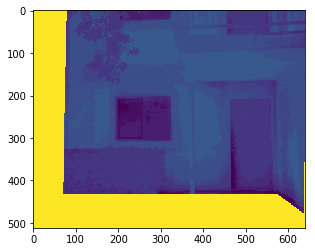

In [318]:
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(thermal_tab.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

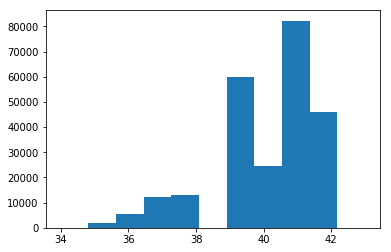

((array([0.0000e+00, 1.8470e+03, 5.3300e+03, 1.2370e+04, 1.2951e+04,
         0.0000e+00, 5.9775e+04, 2.4743e+04, 8.2279e+04, 4.5838e+04,
         1.6000e+01]),
  array([34.        , 34.81818182, 35.63636364, 36.45454545, 37.27272727,
         38.09090909, 38.90909091, 39.72727273, 40.54545455, 41.36363636,
         42.18181818, 43.        ]),
  <a list of 11 Patch objects>),
 None)

In [352]:
from matplotlib import pyplot as plt

# x = np.random.randint(25,100,25)
# y = np.random.randint(175,255,25)
# z = np.hstack((x,y))
# z = z.reshape((50,1))
# z = np.float32(z)
plt.hist(segmented_image_copped,11,[34,43]),plt.show()


In [320]:
segmented_image_f = np.float32(segmented_image)

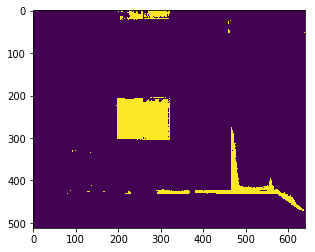

In [333]:
th = cv2.threshold(segmented_image_f,37,255,cv2.THRESH_BINARY)[1]
thresholded = th.astype(np.uint8)
thresholded = np.invert(thresholded)
plt.figure()
plt.imshow(thresholded)

In [334]:
thresholded = binary_dilation(thresholded, rectangle(1,5))

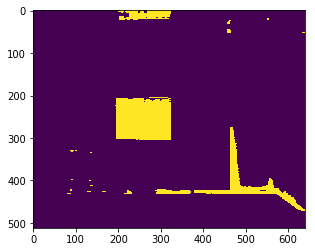

In [335]:
plt.figure()
plt.imshow(thresholded)

In [336]:
# thresholded = binary_erosion(thresholded, rectangle(5,1))
# plt.figure()
# plt.imshow(thresholded)

In [337]:
thresholded_2 = thresholded.astype(np.uint8)
contours, hierarchy = cv2.findContours(thresholded_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

### Create RGB images

In [338]:
thermal_im = 255*(thermal_tab - np.min(thermal_tab))/np.ptp(thermal_tab).astype(int)

In [339]:
thermal_im = cv2.cvtColor(thermal_im.astype(np.uint8),cv2.COLOR_GRAY2RGB)

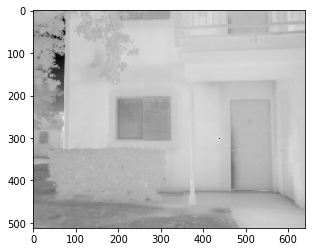

In [340]:
plt.figure()
plt.imshow(thermal_im)

In [341]:
mask0 = np.zeros(thermal_im.shape, np.uint8)
borders_im = cv2.drawContours(mask0, contours, -1, (255,0,0),3)

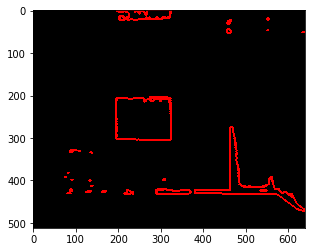

In [342]:
plt.figure()
plt.imshow(borders_im)

#### superimpose images


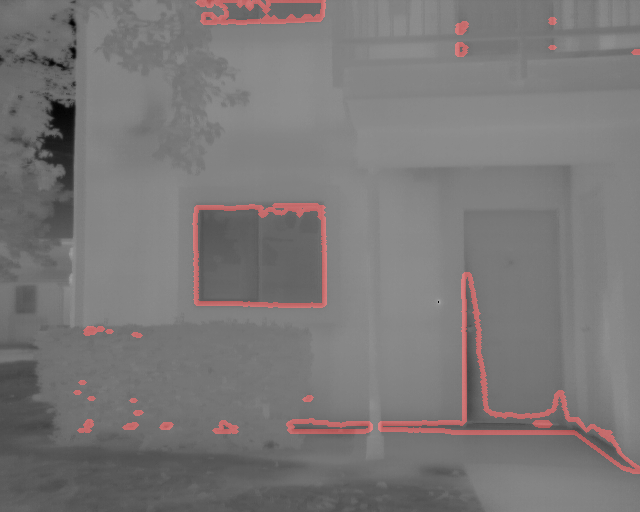

In [343]:
thermal_im_1 = Image.fromarray(thermal_im)
borders_im_1 = Image.fromarray(borders_im)
thermal_im_1 = thermal_im_1.convert("RGBA")
borders_im_1 = borders_im_1.convert("RGBA")
new_img = Image.blend(thermal_im_1, borders_im_1, 0.35)
new_img

In [345]:
new_img.save('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Veracruz/Thermal_preproc/detected_leaks_DJI_0490.png')


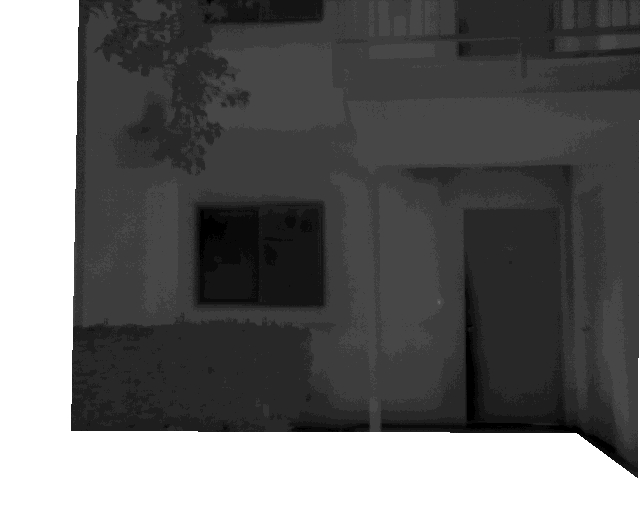

In [344]:
# mask = np.load('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Alameda_December_2019/masks_thm/DJI_0351.npy')
# mask = np.array(mask, dtype=bool)
segmented_image_1 = Image.fromarray(np.float32(segmented_image))
segmented_image_im = 255*(segmented_image_1 - np.min(segmented_image_1))/np.ptp(segmented_image_1).astype(int)
segmented_image_im = cv2.cvtColor(segmented_image_im.astype(np.uint8),cv2.COLOR_GRAY2RGB)
crop_color = (255, 255, 255)
segmented_image_im[np.where(np.logical_not(mask))] = crop_color
segmented_image_im = Image.fromarray(segmented_image_im)
segmented_image_im = segmented_image_im.convert("RGBA")
segmented_image_im

In [346]:
segmented_image_im.save('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Veracruz/Thermal_preproc/quantized_DJI_0490.png')


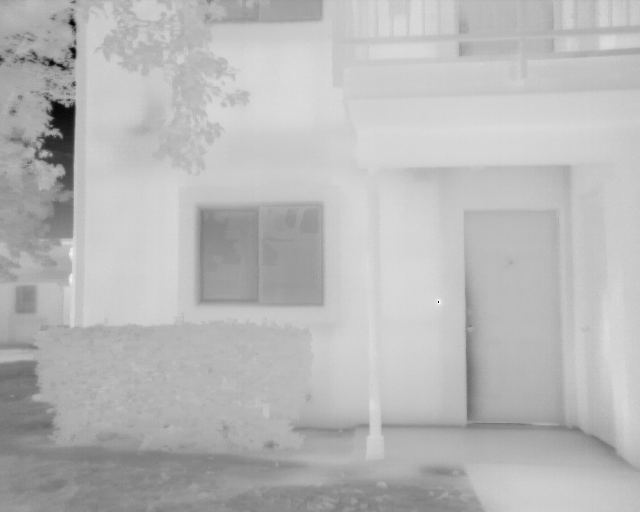

In [347]:
thermal_im_1

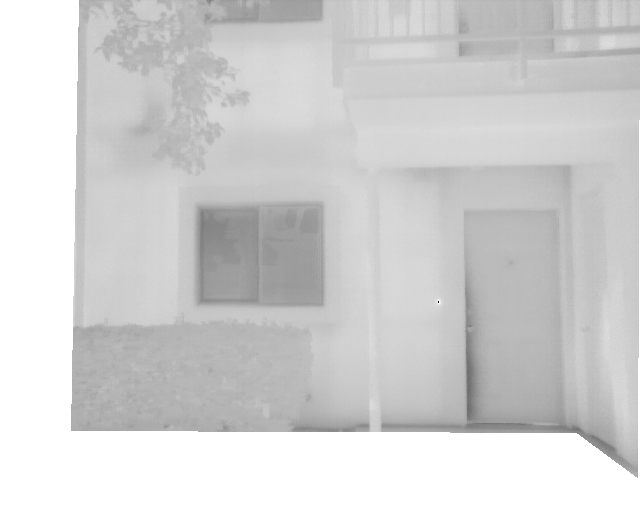

In [350]:
thermal_im_2 = np.array(thermal_im_1)
crop_color = (255, 255, 255,255)
thermal_im_2[np.where(np.logical_not(mask))] = crop_color
thermal_im_2 = Image.fromarray(thermal_im_2)
thermal_im_2 = thermal_im_2.convert("RGBA")
thermal_im_2

In [351]:
thermal_im_2.save('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Veracruz/Thermal_preproc/cropped_DJI_0490.png')
